In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy, os
from cartopy import feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy import crs as ccrs
from erddapy import ERDDAP
import datetime as dt
import json
import numpy as np
from cmocean import cm
import cmocean

from geopy.distance import vincenty
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

__Figure for MBON propsal__

Data sources to illustrate:
    - Rockfish Cruise stations
    - Calcofi
	- Glider lines
	- Wind/Wave buoys
	- ATN tracks
	- HFR
	- Chl-a
	- SST
	- eDNA - ships, LRAUV tracks, point sample

In [2]:
# Mapping helper function
def make_map(projection=ccrs.PlateCarree(),extent=(-130.5,-116.75,32,42)):
    fig, ax = plt.subplots(
        subplot_kw={'projection': projection},
        figsize=(12, 15)
    )
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 22}
    gl.ylabel_style = {'size': 22}
    gl.ylocator = mticker.FixedLocator(range(32,48,4))
    gl.xlocator = mticker.FixedLocator(range(-128,-100,4))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    land_10m  = cfeature.NaturalEarthFeature(category='physical', name='land',
                            scale='10m', facecolor=cfeature.COLORS['land'], edgecolor='k')
    ax.add_feature(land_10m,zorder=20)
#     ocean_50m  = cfeature.NaturalEarthFeature(category='physical', name='ocean',
#                             scale='50m', facecolor=cfeature.COLORS['water'])
#     ax.add_feature(ocean_50m,zorder=0)
    return fig, ax

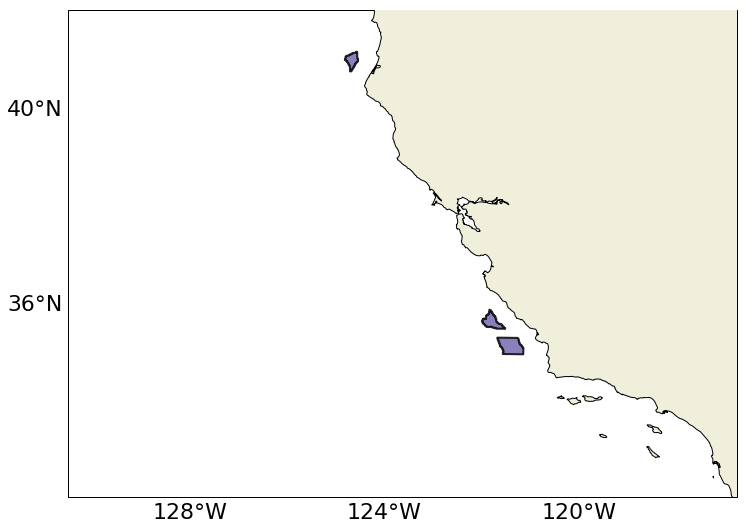

In [3]:
fig,ax = make_map()
fname = '/Users/patrick/Documents/CeNCOOS/store-locator/data/boem_call_areas_10_01_18/BOEM Call_Areas_10_01_18.shp'
GF_shape = Reader(fname)
ax.add_geometries(GF_shape.geometries(),ccrs.UTM(zone=10),facecolor='#756bb1',alpha=.85,edgecolor="k",lw=2,zorder=1)


# GF_shape.

## Rockfish Cruise station data

## HFR 6-km radar data

In [43]:
hfr_url = '/Users/patrick/Downloads/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd.nc'
hfr_ds = xr.open_dataset(hfr_url)

In [44]:
hfr_ds

<xarray.Dataset>
Dimensions:   (lat: 138, lon: 234, time: 30350)
Coordinates:
    time_run  (time) datetime64[ns] ...
  * time      (time) datetime64[ns] 2011-10-01 2011-10-01 2011-10-01 ...
  * lat       (lat) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * lon       (lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Data variables:
    u         (time, lat, lon) float32 ...
Attributes:
    netcdf_library_version:  4.1.3
    format_version:          HFRNet_1.0.0
    product_version:         HFRNet_1.1.05
    Conventions:             CF-1.4
    title:                   Near-Real Time Surface Ocean Velocity, U.S. West...
    institution:             Scripps Institution of Oceanography
    source:                  Surface Ocean HF-Radar
    history:                 18-Mar-2019 08:35:04: NetCDF file created\n18-Ma...
    references:              Terrill, E. et al., 2006. Data Management and Re...
    creator_name:            Mark Otero
    creator_email:    

In [27]:
test

RuntimeError: NetCDF: I/O failure

RuntimeError: NetCDF: Access failure

In [ ]:
coverage

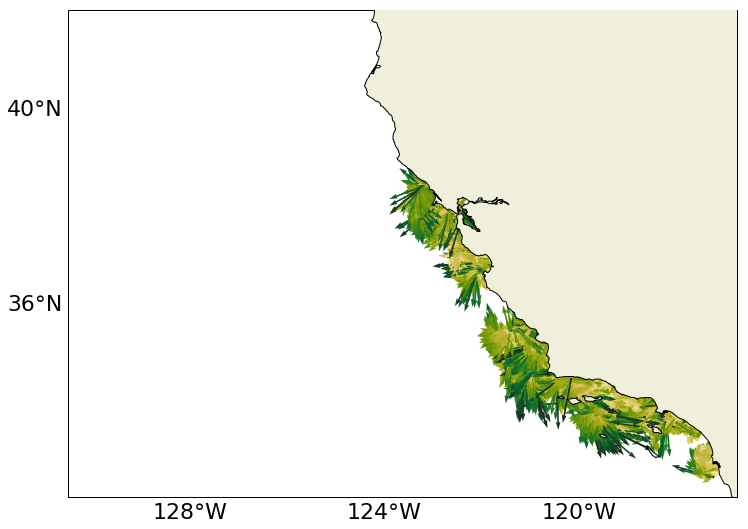

In [6]:
fig, ax = make_map()

# ax.quiver(xx[ix],yy[ix],u.values[ix],v.values[ix],speed[ix],
#           cmap=cm.speed,
#           scale_units='xy',
#           scale=.5,)
# ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker='.',c='k')

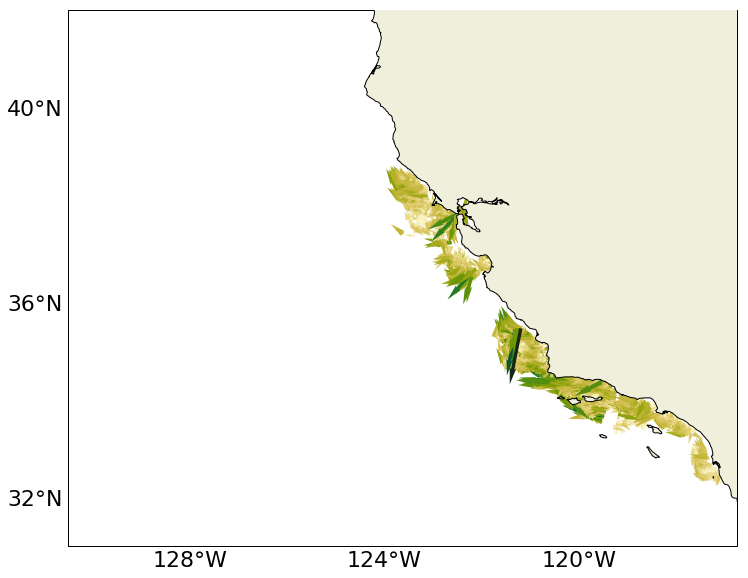

In [12]:
fig, ax = make_map()
ax.quiver(xx[::2,::2],yy[::2,::2],u[::2,::2],v[::2,::2],speed[::2,::2],
          cmap=cm.speed,
          scale_units='xy',
          scale=.75,
         width=.005,
         headwidth=2)
# ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker='.',c='k')

## Get Glider lines

In [28]:
e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap',
    protocol='tabledap',
)
min_lon,max_lon,min_lat,max_lat= (-130,-116.75,32,42)
min_time = "2018-01-01T00:00:00Z"
max_time = "2019-01-01T00:00:00Z"
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_time': min_time,
    'max_time': max_time,
    'cdm_data_type': 'trajectoryprofile'
}
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

In [37]:
e.variables = variables
variables = [
 'latitude',
 'longitude',
 'time',
]
gliders_to_plot = ["sp058-20180126T1753",'UW157-20180417T1832',"Nemesis-20180830T0000","sp025-20180430T1727"]
for i, glider_id in enumerate(gliders_to_plot):
    e.dataset_id = glider_id
    df = e.to_pandas(
        index_col='time (UTC)',
        parse_dates=True,
    ).dropna()
    df['glider_name'] = glider_id
    print("Pulling glider: {0}".format(glider_id))
    if i == 0:
        df_gliders = df
    else:
        df_array = (df_gliders, df)
        df_gliders = pd.concat(df_array)

Pulling glider: sp058-20180126T1753
Pulling glider: UW157-20180417T1832
Pulling glider: Nemesis-20180830T0000
Pulling glider: sp025-20180430T1727


In [27]:
e.variables

''

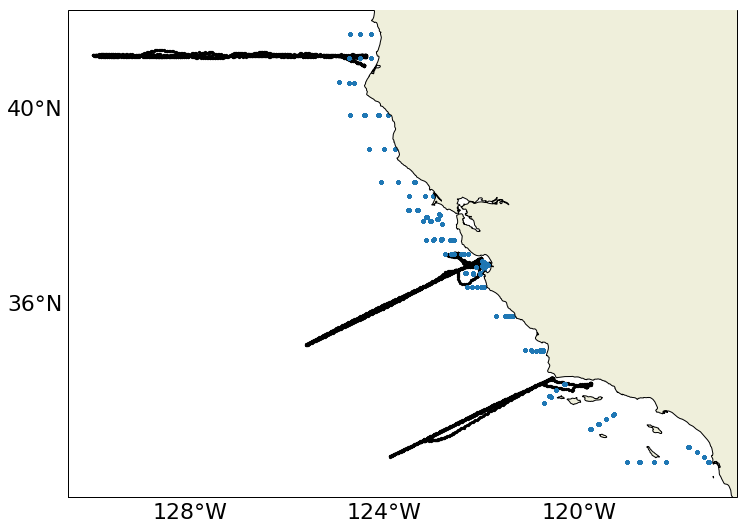

In [43]:
gliders_to_plot = ["sp058-20180126T1753",'UW157-20180417T1832',"Nemesis-20180830T0000","sp025-20180430T1727"]
fig, ax = make_map()
# ax.quiver(xx,yy,u,v,speed,cmap=cm.speed,units='x',scale=3,scale_units='x') # HFR
# for i, name in enumerate(df_gliders['glider_name'].unique()):
for i, name in enumerate(gliders_to_plot):
    df_temp = df_gliders[df_gliders['glider_name']==name]
    ax.scatter(df_temp['longitude (degrees_east)'], df_temp['latitude (degrees_north)'],s=20,marker='.',c='k') # Gliders
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker='.') # Rockfish


### Coastal Relief Model

In [44]:
fname = './crm.nc'
ds_bathy = xr.open_dataset(fname)
elev = ds_bathy['Band1'] * -1
llon, llat = np.meshgrid(ds_bathy['lon'], ds_bathy['lat'])
levels = np.append(np.arange(-10,501,100), np.array((1000,1500,2000,3000,5000)))

## ACCESS Trawl stations

In [45]:
# Mapping helper function
def make_map_inlet(projection=ccrs.PlateCarree(),extent=(-123.75,-122.25,36.9,38.75)):
    fig, ax = plt.subplots(
        subplot_kw={'projection': projection},
        figsize=(6, 6)
    )
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 22}
    gl.ylabel_style = {'size': 22}
    gl.ylocator = mticker.FixedLocator(range(32,48,4))
    gl.xlocator = mticker.FixedLocator(range(-128,-100,4))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    land_10m  = cfeature.NaturalEarthFeature(category='physical', name='land',
                            scale='10m', facecolor=cfeature.COLORS['land'], edgecolor='k',linewidths=2)
    ax.add_feature(land_10m,)
#     ocean_50m  = cfeature.NaturalEarthFeature(category='physical', name='ocean',
#                             scale='50m', facecolor=cfeature.COLORS['water'])
#     ax.add_feature(ocean_50m,zorder=0)
    return fig, ax

# Mapping helper function
def make_map_inlet_humboldt(projection=ccrs.PlateCarree(),extent=(-125.85,-124,40.325,41.75)):
    fig, ax = plt.subplots(
        subplot_kw={'projection': projection},
#         figsize=(6, 6)
    )
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 22}
    gl.ylabel_style = {'size': 22}
    gl.ylocator = mticker.FixedLocator(range(32,48,4))
    gl.xlocator = mticker.FixedLocator(range(-128,-100,4))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    land_10m  = cfeature.NaturalEarthFeature(category='physical', name='land',
                            scale='10m', facecolor=cfeature.COLORS['land'], edgecolor='k',linewidths=2)
    ax.add_feature(land_10m,)
#     ocean_50m  = cfeature.NaturalEarthFeature(category='physical', name='ocean',
#                             scale='50m', facecolor=cfeature.COLORS['water'])
#     ax.add_feature(ocean_50m,zorder=0)
    return fig, ax

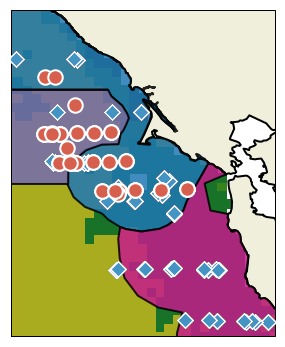

In [85]:
fname = "access_trawl.csv"
df_access = pd.read_csv(fname)
df_access['eventDate'] = pd.to_datetime(df_access['eventDate'])
station = df_access.groupby('eventDate').first()
station = station[station.index > dt.datetime(2013,1,1)]
fig, ax = make_map_inlet()
im = ax.pcolormesh(xx, yy, seasonal,transform=ccrs.PlateCarree(),cmap=plt.cm.get_cmap('cmo.speed', len(cat_key)))
plt.FuncFormatter(lambda val, loc: int(cat_values[np.where(ticks == val)][0]))
fname = '/Users/patrick/Documents/CeNCOOS/store-locator/data/sanctuary_files/gfnms_py2/GFNMS_py.shp'
GF_shape = Reader(fname)
ax.add_geometries(GF_shape.geometries(),ccrs.PlateCarree(),edgecolor='k',alpha=.85,lw=2,zorder=1)
fname = '/Users/patrick/Documents/CeNCOOS/store-locator/data/sanctuary_files/mbnms_py2/mbnms_py.shp'
GF_shape = Reader(fname)
ax.add_geometries(GF_shape.geometries(),ccrs.PlateCarree(),facecolor='#c51b8a',alpha=.85,edgecolor="k",lw=2,zorder=1)
fname = '/Users/patrick/Documents/CeNCOOS/store-locator/data/sanctuary_files/cbnms_py2/CBNMS_py.shp'
GF_shape = Reader(fname)
ax.add_geometries(GF_shape.geometries(),ccrs.PlateCarree(),facecolor='#756bb1',alpha=.85,edgecolor="k",lw=2,zorder=1)

cbar = plt.colorbar(im, cax=ax_cb, ticks=ticks,format=formatter)
cbar.ax.tick_params(labelsize=20) 

# CS = ax.contourf(llon,llat,elev,levels,alpha=.75,cmap=cm.deep)
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'],s=110,edgecolor='w', marker='D',c='#4393c3',zorder=4) # Rockfish
ax.scatter(station['Lon'],station['Lat'],c='#d6604d',edgecolor='w',s=210,marker='o',linewidths=2,zorder=4)

plt.savefig('df_bay_insert.png',dpi=300, bbox_inches='tight', pad_inches=0)

In [46]:
fname = './etopo1.nc'
ds_bathy = xr.open_dataset(fname)
elev = ds_bathy['Band1'] * -1
llon, llat = np.meshgrid(ds_bathy['lon'], ds_bathy['lat'])
levels = np.append(np.arange(-10,501,100), np.array((1000,1500,2000,3000,16000)))


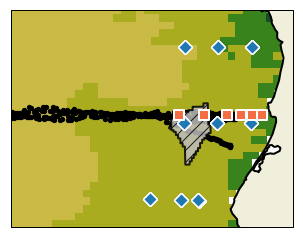

In [48]:
fname = './trinidad_head_station_locations.csv'
df_thl = pd.read_csv(fname)

fig, ax = make_map_inlet_humboldt()
im = ax.pcolormesh(xx, yy, seasonal,transform=ccrs.PlateCarree(),cmap=plt.cm.get_cmap('cmo.speed', len(cat_key)))
# im = ax.pcolormesh(xx, yy, seasonal,transform=ccrs.PlateCarree(),cmap='cmo.amp')
# divider = make_axes_locatable(ax)
# ax_cb = divider.new_horizontal(size="5%", pad=.45, axes_class=plt.Axes)
# fig.add_axes(ax_cb)
# formatter = plt.FuncFormatter(lambda val, loc: int(cat_values[int(val)]))
# formatter = plt.FuncFormatter(lambda val, loc: int(cat_values[np.where(ticks == val)][0]))

# cbar = plt.colorbar(im, cax=ax_cb, ticks=ticks,format=formatter)
# cbar.ax.tick_params(labelsize=20) 
# CS = ax.contourf(llon,llat,elev,levels,alpha=.75,cmap=cm.deep)
for i, name in enumerate(gliders_to_plot):
    df_temp = df_gliders[df_gliders['glider_name']==name]
    ax.scatter(df_temp['longitude (degrees_east)'], df_temp['latitude (degrees_north)'],s=75,marker='.',c='k',zorder=1) # Gliders

ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'],s=90, marker='D',edgecolor='w',zorder=2) # Rockfish

ax.scatter(df_thl['Lon'][:-3], df_thl['Lat'][:-3],marker='s',edgecolor='w',linewidths=2,c='#f46d43',s=115,zorder=2)

fname = '/Users/patrick/Documents/CeNCOOS/store-locator/data/boem_call_areas_10_01_18/BOEM Call_Areas_10_01_18.shp'
GF_shape = Reader(fname)
ax.add_geometries(GF_shape.geometries(),ccrs.UTM(zone=10),facecolor='#bdbdbd',alpha=.85,edgecolor="k",lw=2,zorder=1,hatch='//')


plt.savefig('trinidad_line_insert.png',dpi=300, bbox_inches='tight', pad_inches=0)

### Add ATN Tracks

In [49]:
e = ERDDAP(
    server='https://coastwatch.pfeg.noaa.gov/erddap',
    protocol='tabledap',
)
e.dataset_id = "gtoppAT"

# e.constraints = {
#     'latitude>=': min_lat,
#     'latitude<=': max_lat,
#     'longitude>=': 360 + min_lon,
#     'longitude<=': 360 + max_lon,
# }

e.variables = [
 'time',
 'latitude',
 'longitude',
 'toppID',
 'commonName',
 'yearDeployed',
 'isDrifter'
]

atn_df = e.to_pandas().dropna()

print(atn_df['commonName'].unique())
atn_df['longitude (degrees_east)'] = -360+atn_df['longitude (degrees_east)']

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


['Atlantic Sailfish' 'Basking Shark' 'Black Marlin'
 'Black-footed Albatross' 'Blue Marlin' 'Blue Shark' 'Blue Whale'
 'California Sea Lion' 'Common Thresher Shark' 'Crabeater Seal'
 'Devil Ray' 'Dolphin-fish' 'Fin Whale' 'Galapagos Sea Lion'
 'Galapagos Shark' 'Greenland Shark' 'Grey Reef Shark' 'Hawksbill Turtle'
 'Humboldt Squid' 'Humpback Whale' 'Juvenile White Shark'
 'Laysan Albatross' 'Leatherback Sea Turtle' 'Loggerhead Sea Turtle'
 'Manta Ray' 'Mediterranean Spearfish' 'Northern Elephant Seal'
 'Northern Fur Seal' 'Ocean Sunfish' 'Oceanic Whitetip Shark'
 'Pacific Sailfish' 'Porbeagle Shark' 'Salmon Shark' 'Sandtiger Shark'
 'Shortbill Spearfish' 'Shortfin Mako Shark' 'Silky Shark'
 'Silvertip Shark' 'Smooth Hammerhead' 'Sooty Shearwater'
 'South American Sea Lion' 'Southern Elephant Seal' 'Sperm Whale'
 'Striped Marlin' 'Swordfish' 'Tiger Shark' 'Weddell Seal' 'Whale Shark'
 'White Marlin' 'White Shark' 'Yellowfin Tuna']


In [50]:
def plot_seal_tracks(ax, atn_df):
    """ Plot the atn elephan seal tracks deployed after 2016"""
    elph_seals = atn_df[(atn_df['commonName'] == "Northern Elephant Seal")&(atn_df['yearDeployed'] >= 2016)]
    for t_id in elph_seals['toppID'].unique()[:8]:
        tag = elph_seals[(elph_seals['toppID'] == t_id)]
        ax.plot(tag['longitude (degrees_east)'], tag['latitude (degrees_north)'], marker="o",lw=2,ms=7,mew=1.5,mec='.95',c="#7F7F7F")

In [246]:
# elph_seals = atn_df[(atn_df['commonName'] == "Northern Elephant Seal")&(atn_df['yearDeployed'] >= 2016)]
# elph_seals['toppID'].un

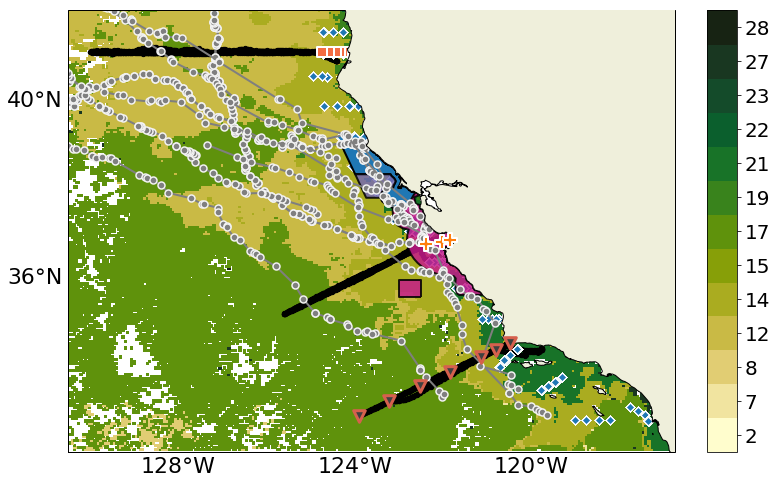

In [57]:
gliders_to_plot = ["sp058-20180126T1753",'UW157-20180417T1832',"Nemesis-20180830T0000","sp025-20180430T1727"]
fig, ax = make_map()
im = ax.pcolormesh(xx, yy, seasonal,transform=ccrs.PlateCarree(),cmap=plt.cm.get_cmap('cmo.speed', len(cat_key)))
# im = ax.pcolormesh(xx, yy, seasonal,transform=ccrs.PlateCarree(),cmap='cmo.amp')
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=.45, axes_class=plt.Axes)
fig.add_axes(ax_cb)
formatter = plt.FuncFormatter(lambda val, loc: int(cat_values[int(val)]))
formatter = plt.FuncFormatter(lambda val, loc: int(cat_values[np.where(ticks == val)][0]))

cbar = plt.colorbar(im, cax=ax_cb, ticks=ticks,format=formatter)
cbar.ax.tick_params(labelsize=20) 

for i, name in enumerate(gliders_to_plot):
    df_temp = df_gliders[df_gliders['glider_name']==name]
    ax.scatter(df_temp['longitude (degrees_east)'], df_temp['latitude (degrees_north)'],s=75,marker='.',c='k') # Gliders

    
    
# temp_df = rf_2015[(rf_2015['station'] < 200) & (rf_2015['station'] < 200)]   
# ax.scatter(temp_df['longitude (degrees_east)'], temp_df['latitude (degrees_north)'], marker='.') # Rockfish
plot_seal_tracks(ax, atn_df)

ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker='D',edgecolor='w') # Rockfish
ax.scatter(df_thl['Lon'][:-3], df_thl['Lat'][:-3],marker='s',edgecolor='w',linewidths=2,c='#f46d43',s=115)

ax.scatter(df_c['longitude (degrees_east)'], df_c['latitude (degrees_north)'],c=".25", marker='v',linewidths=3,edgecolor='#d6604d', s=135,zorder=50) # calcofi
ax.scatter([-122.022,-122.378,-121.847],[36.747,36.697,36.797],marker='P',s=170,zorder=21,linewidths=2,edgecolor='w')
# fname = os.path.join('MBON_all_map.png')
fname = '/Users/patrick/Documents/CeNCOOS/store-locator/data/sanctuary_files/gfnms_py2/GFNMS_py.shp'
GF_shape = Reader(fname)
ax.add_geometries(GF_shape.geometries(),ccrs.PlateCarree(),edgecolor='k',lw=2)
fname = '/Users/patrick/Documents/CeNCOOS/store-locator/data/sanctuary_files/mbnms_py2/mbnms_py.shp'
GF_shape = Reader(fname)
ax.add_geometries(GF_shape.geometries(),ccrs.PlateCarree(),facecolor='#c51b8a',alpha=.85,edgecolor="k",lw=2)
fname = '/Users/patrick/Documents/CeNCOOS/store-locator/data/sanctuary_files/cbnms_py2/CBNMS_py.shp'
GF_shape = Reader(fname)
ax.add_geometries(GF_shape.geometries(),ccrs.PlateCarree(),facecolor='#756bb1',alpha=.85,edgecolor="k",lw=2)

plt.savefig("MBON_all_map.png", dpi = 300, bbox_inches='tight', pad_inches=.5)

In [173]:
rf_2015['station'].unique()

array([139, 138, 237, 453, 454, 455, 461, 463, 464, 471, 473, 474, 112,
       115, 116, 114, 119, 123, 124, 125, 126, 131, 132, 133, 134, 135,
       117, 109, 110, 441, 442, 422, 404, 403, 402, 401, 484, 483, 482,
       481, 411, 412, 413, 414, 425, 424, 423, 491, 492, 493, 494, 495,
       443, 444, 211, 162, 160, 156, 152, 475, 602, 603, 605, 621, 623,
       625, 611, 613, 615, 165, 167, 171, 127, 101, 103, 104, 105, 106,
       154])

### SST Data

In [18]:
# ghrsst_NAVO-L4HR1m-GLOB-K10_SST
url="https://thredds.jpl.nasa.gov/thredds/dodsC/ncml_aggregation/OceanTemperature/ghrsst/aggregate__ghrsst_NAVO-L4HR1m-GLOB-K10_SST.ncml"
sst_ds = xr.open_dataset(url)
sst_recent = sst_ds.sel(time=slice(dt.datetime(2018,5,1),dt.datetime(2018,6,1)), lat=slice(42, 31), lon=slice(-130.5,-116.75)) #extent=(-130.5,-116.75,31,42))
xx,yy = np.meshgrid(sst_recent['lon'], sst_recent['lat'])

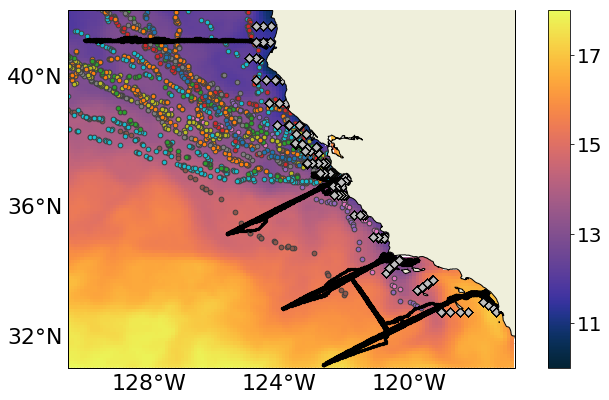

In [19]:
fig, ax = make_map()
im = ax.pcolormesh(xx, yy, sst_recent['analysed_sst'].mean(dim='time')-273.15, cmap=cm.thermal, vmin=10, vmax=18)
plot_seal_tracks(ax, atn_df)
ax.scatter(df_gliders['longitude (degrees_east)'], df_gliders['latitude (degrees_north)'],s=20,marker='.',c='k') # Gliders
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'],marker="D",edgecolor='k',c='.75') # Rockfish

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=.45, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = plt.colorbar(im, cax=ax_cb,ticks=range(9,21,2))
cbar.ax.tick_params(labelsize=20) 
 
fname = os.path.join('MBON_sst_map.png')
# plt.savefig(fname, dpi = 300, bbox_inches='tight', pad_inches=.5)

## Georeference seascape raster

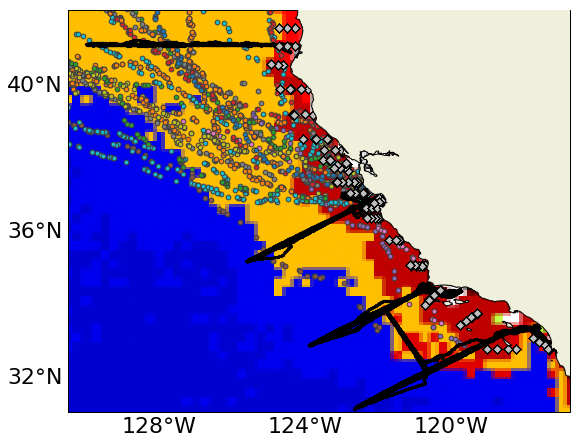

In [29]:
fig, ax = make_map()

img_extent = [-135, -90, 0, 60]
fname = "./MAY_CCS_seascape.jpg"

img = plt.imread(fname)
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
plot_seal_tracks(ax, atn_df)
ax.scatter(df_gliders['longitude (degrees_east)'], df_gliders['latitude (degrees_north)'],s=20,marker='.',c='k') # Gliders
ax.scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'],marker="D",edgecolor='k',c='.75') # Rockfish


fname = os.path.join('MBON_seascape_map.png')
plt.savefig(fname, dpi = 300, bbox_inches='tight', pad_inches=.5)

### Make Panel Maps

In [ ]:
# Mapping helper function
def make_map_panel(projection=ccrs.PlateCarree(),extent=(-130.5,-116.75,31,42),n=4,sharex=True):
    fig, ax = plt.subplots(nrows=2,ncols=2,
        subplot_kw={'projection': projection}
    )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.05, hspace=.05)
    fig.set_size_inches(7,6)

    for i, ax_i in enumerate(ax.flatten()):
        ax_i.set_extent(extent, crs=ccrs.PlateCarree())
        gl = ax_i.gridlines(draw_labels=True,)
        gl.xlines = False
        gl.ylines = False
        gl.ylabels_right = False
        ax_i.coastlines('50m')
        ocean_50m  = cfeature.NaturalEarthFeature(category='physical', name='ocean',
                                scale='50m', facecolor=cfeature.COLORS['water'])
        ax_i.add_feature(ocean_50m,zorder=0)
        plt.xticks(rotation='vertical')
        gl.xlocator = mticker.FixedLocator(np.arange(-129,-117,3))
        gl.ylocator = mticker.FixedLocator(np.arange(32,42,3))
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16}
        gl.ylabel_style = {'size': 16}
        if i == 0:
            gl.xlabels_bottom= False
            gl.xlabels_top= False
        elif i == 1:
            gl.ylabels_left = False
            gl.xlabels_bottom= False
            gl.xlabels_top= False
        elif i == 2:
            gl.ylabels_right= False
            gl.xlabels_top= False
        else:
            gl.ylabels_left= False
            gl.ylabels_right= False
            gl.xlabels_top= False

    return fig, ax.flatten()

# fig, ax = make_map_panel()

In [ ]:
fig, ax = make_map_panel()
ax[0].quiver(xx[ix],yy[ix],u.values[ix],v.values[ix],speed[ix],
          cmap=cm.speed,
          scale_units='xy',
          scale=.75) # HFR
ax[1].scatter(df_gliders['longitude (degrees_east)'], df_gliders['latitude (degrees_north)'],s=5,marker='.',c='k') # Gliders
ax[2].scatter(rf_2015['longitude (degrees_east)'], rf_2015['latitude (degrees_north)'], marker=".",c='k',s=3) # Rockfish
plot_seal_tracks(ax[3], atn_df)

fname = os.path.join('MBON_panel_map.png')
plt.savefig(fname, dpi = 300, bbox_inches='tight', pad_inches=.5)

In [ ]:
import folium
from folium.plugins import Fullscreen, MarkerCluster

m = folium.Map(location=[37.5, -122], tiles='OpenStreetMap', zoom_start=4)

Fullscreen(position='topright', force_separate_button=True).add_to(m)

marker_cluster0 = MarkerCluster(name='Observations')
marker_cluster0.add_to(m);

In [ ]:
# url = 'http://oos.soest.hawaii.edu/thredds/wms/hioos/satellite/dhw_5km'
# w0 = folium.WmsTileLayer(
#     url,
#     name='Sea Surface Temperature',
#     fmt='image/png',
#     layers='CRW_SST',
#     attr='PacIOOS TDS',
#     overlay=True,
#     transparent=True)

url = 'http://hfrnet.ucsd.edu/thredds/wms/HFRNet/USEGC/6km/hourly/RTV'
w1 = folium.WmsTileLayer(
    url,
    name='HF Radar',
    fmt='image/png',
    layers='surface_sea_water_velocity',
    attr='HFRNet',
    overlay=True,
    transparent=True)

# w0.add_to(m)
w1.add_to(m);

In [ ]:
def embed_map(m):
    from IPython.display import HTML

    m.save('index.html')
    with open('index.html') as f:
        html = f.read()

    srcdoc = html.replace('"', '&quot;')
    iframe = f'<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    return HTML(iframe)